# Predict the subcellular localisation of a protein using CNNs

# Librairies import

In [120]:
# Basic libraries
import os
import random as python_random
import zipfile
import requests

# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Progress tracking
from tqdm.auto import tqdm
from tqdm import tqdm

# TensorFlow and Keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D, GlobalAveragePooling1D
from keras.layers import Add, AveragePooling1D, BatchNormalization, Activation, Input, ReLU
from keras.utils import to_categorical, plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

# Sklearn libraries
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import sklearn.metrics

# Scikeras wrapper
from scikeras.wrappers import KerasClassifier


# Data Loading

If required, uncomment and run the following lines:

In [121]:
# from google.colab import drive
# drive.mount("/content/drive")
# %cd  /content/drive/MyDrive
# %mkdir M2BI_DRIVE
# %cd  /content/drive/MyDrive/M2BI_DRIVE
# %pwd

Download the data

In [122]:
def download_data(url, file_name):
    url= url
    datasetFolderPath = "dataset/"
    file = file_name
    FilePath = os.path.join(datasetFolderPath, file)
    if not os.path.exists(datasetFolderPath):
        os.makedirs(datasetFolderPath)

    def download_file(url, filename):
        response = requests.get(url, stream=True)
        with tqdm.wrapattr(open(filename, "wb"), "write", miniters=1,
                           total=int(response.headers.get('content-length', 0)),
                           desc=filename) as fout:
            for chunk in response.iter_content(chunk_size=4096):
                fout.write(chunk)

    # Download the zip file if it does not exist
    if not os.path.exists(FilePath):
        download_file(url, FilePath)


In [123]:
download_data(url = "https://github.com/JJAlmagro/subcellular_localization/raw/refs/heads/master/notebook%20tutorial/data/reduced_train.npz",
                file_name = "reduced_train.npz")

# Data pretreatment

## Do the one hot encoding

In [124]:
file_data_train = "dataset/reduced_train.npz"

train = np.load(file_data_train)
print("Keys of the train dataset:", train.files)
print("Number of elements in the train dataset:", len(train.files))
print("Shape of the train dataset:", train["X_train"].shape)


X_train = train["X_train"]
Y = train["y_train"]
mask_train = train["mask_train"]

# Print these to visualize.
print("Shape of dataset X", X_train.shape)
print("Shape of dataset Y", Y.shape)
print("Shape of dataset Mask", mask_train.shape)

classes = LabelEncoder()
classes.fit(Y)
classes_Y = classes.transform(Y)

onehot_Y = to_categorical(classes_Y)

print("First 5 rows of X_train:\n", X_train[:5])
print("First 5 elements of Y (original):\n", Y[:5])
print("First 5 rows of mask_train:\n", mask_train[:5])

print("First 5 rows of one-hot encoded Y:\n", onehot_Y[:5])

Keys of the train dataset: ['X_train', 'y_train', 'mask_train']
Number of elements in the train dataset: 3
Shape of the train dataset: (2423, 400, 20)
Shape of dataset X (2423, 400, 20)
Shape of dataset Y (2423,)
Shape of dataset Mask (2423, 400)
First 5 rows of X_train:
 [[[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.48 0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   .

## Split the data set into train and test

In [125]:
# Split the data into training and testing sets, percentage of 80% training and 20% testing.
X_train_cut, X_test, y_train, y_test = train_test_split(X_train, 
                                                        onehot_Y, 
                                                        test_size=0.2, 
                                                        random_state=3, 
                                                        shuffle=True,
                                                        stratify=onehot_Y)

In [126]:
# Validate the shape of the data
print("Shape of X_train_cut:", X_train_cut.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train_cut: (1938, 400, 20)
Shape of X_test: (485, 400, 20)
Shape of y_train: (1938, 10)
Shape of y_test: (485, 10)


# Descriptive statistics

## Barplot of the classes distribution

Number of samples per class: [338 567 535 233 285  63 224  59  60  59]


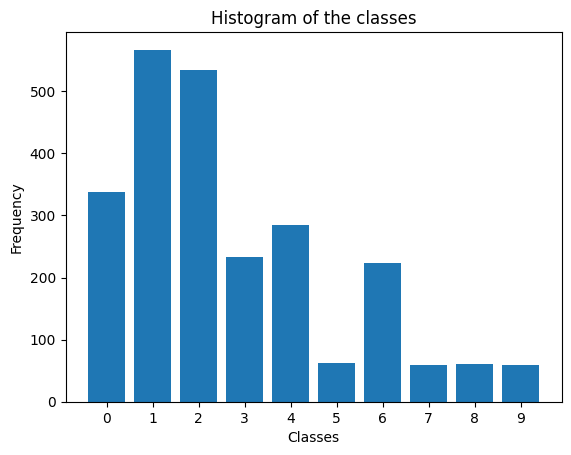

In [127]:
# Plot the barplot of the classes
# Verify that the data is balanced
labels = onehot_Y.argmax(axis=1)
counts = np.bincount(labels)
print("Number of samples per class:", counts)

# Plot a barplot of the labels
plt.bar(range(10), counts, tick_label=range(10))
plt.title("Histogram of the classes")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.show()


The classes are not homogenous in size. 
The NN training will have to be biased towards the smaller classes.

## Barplot of the test and train set separatly, to verify the good stratification

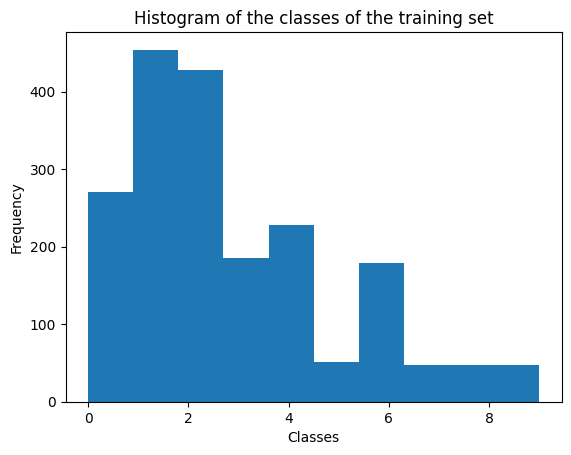

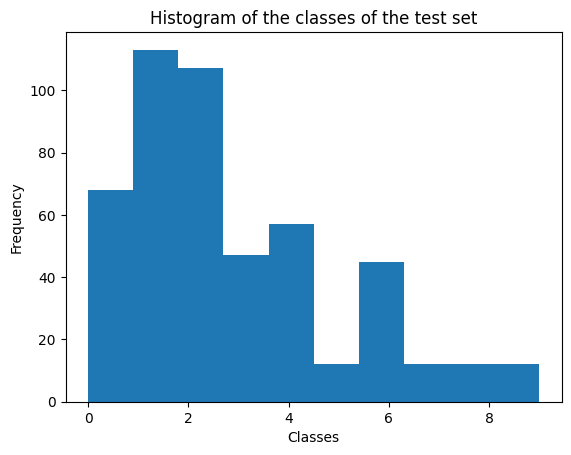

In [128]:
# Plot the histogram of the classes of the training set
plt.hist(np.argmax(y_train, axis=1), bins=10)
plt.title("Histogram of the classes of the training set")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.show()

# Plot the histogram of the classes of the test set
plt.hist(np.argmax(y_test, axis=1), bins=10)
plt.title("Histogram of the classes of the test set")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.show()


The splitting of the two sets is adequate

# CNN

## Creation of the model

In [129]:
def cnn():
    model = Sequential()

    # Add the first 1D convolutional layer
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(400, 20), kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))

    # Add convolutional layers
    model.add(Conv1D(64, kernel_size=3, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))

    # model.add(Conv1D(128, kernel_size=3, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
    # model.add(MaxPooling1D(pool_size=2))
    # model.add(Dropout(0.4))

    # Add flatten layer
    model.add(Flatten())

    # Add fully connected layers
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    # Compile the model
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), 
                  loss='categorical_crossentropy', 
                  weighted_metrics=['accuracy'])
    
    return model



/home/jmaes/miniconda3/envs/bioinfo/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_134 (Conv1D)             │ (None, 398, 32)        │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (None, 199, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 199, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_135 (Conv1D)             │ (None, 197, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (None, 98, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 98, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 410,282 (1.57 MB)

 Trainable params: 410,282 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

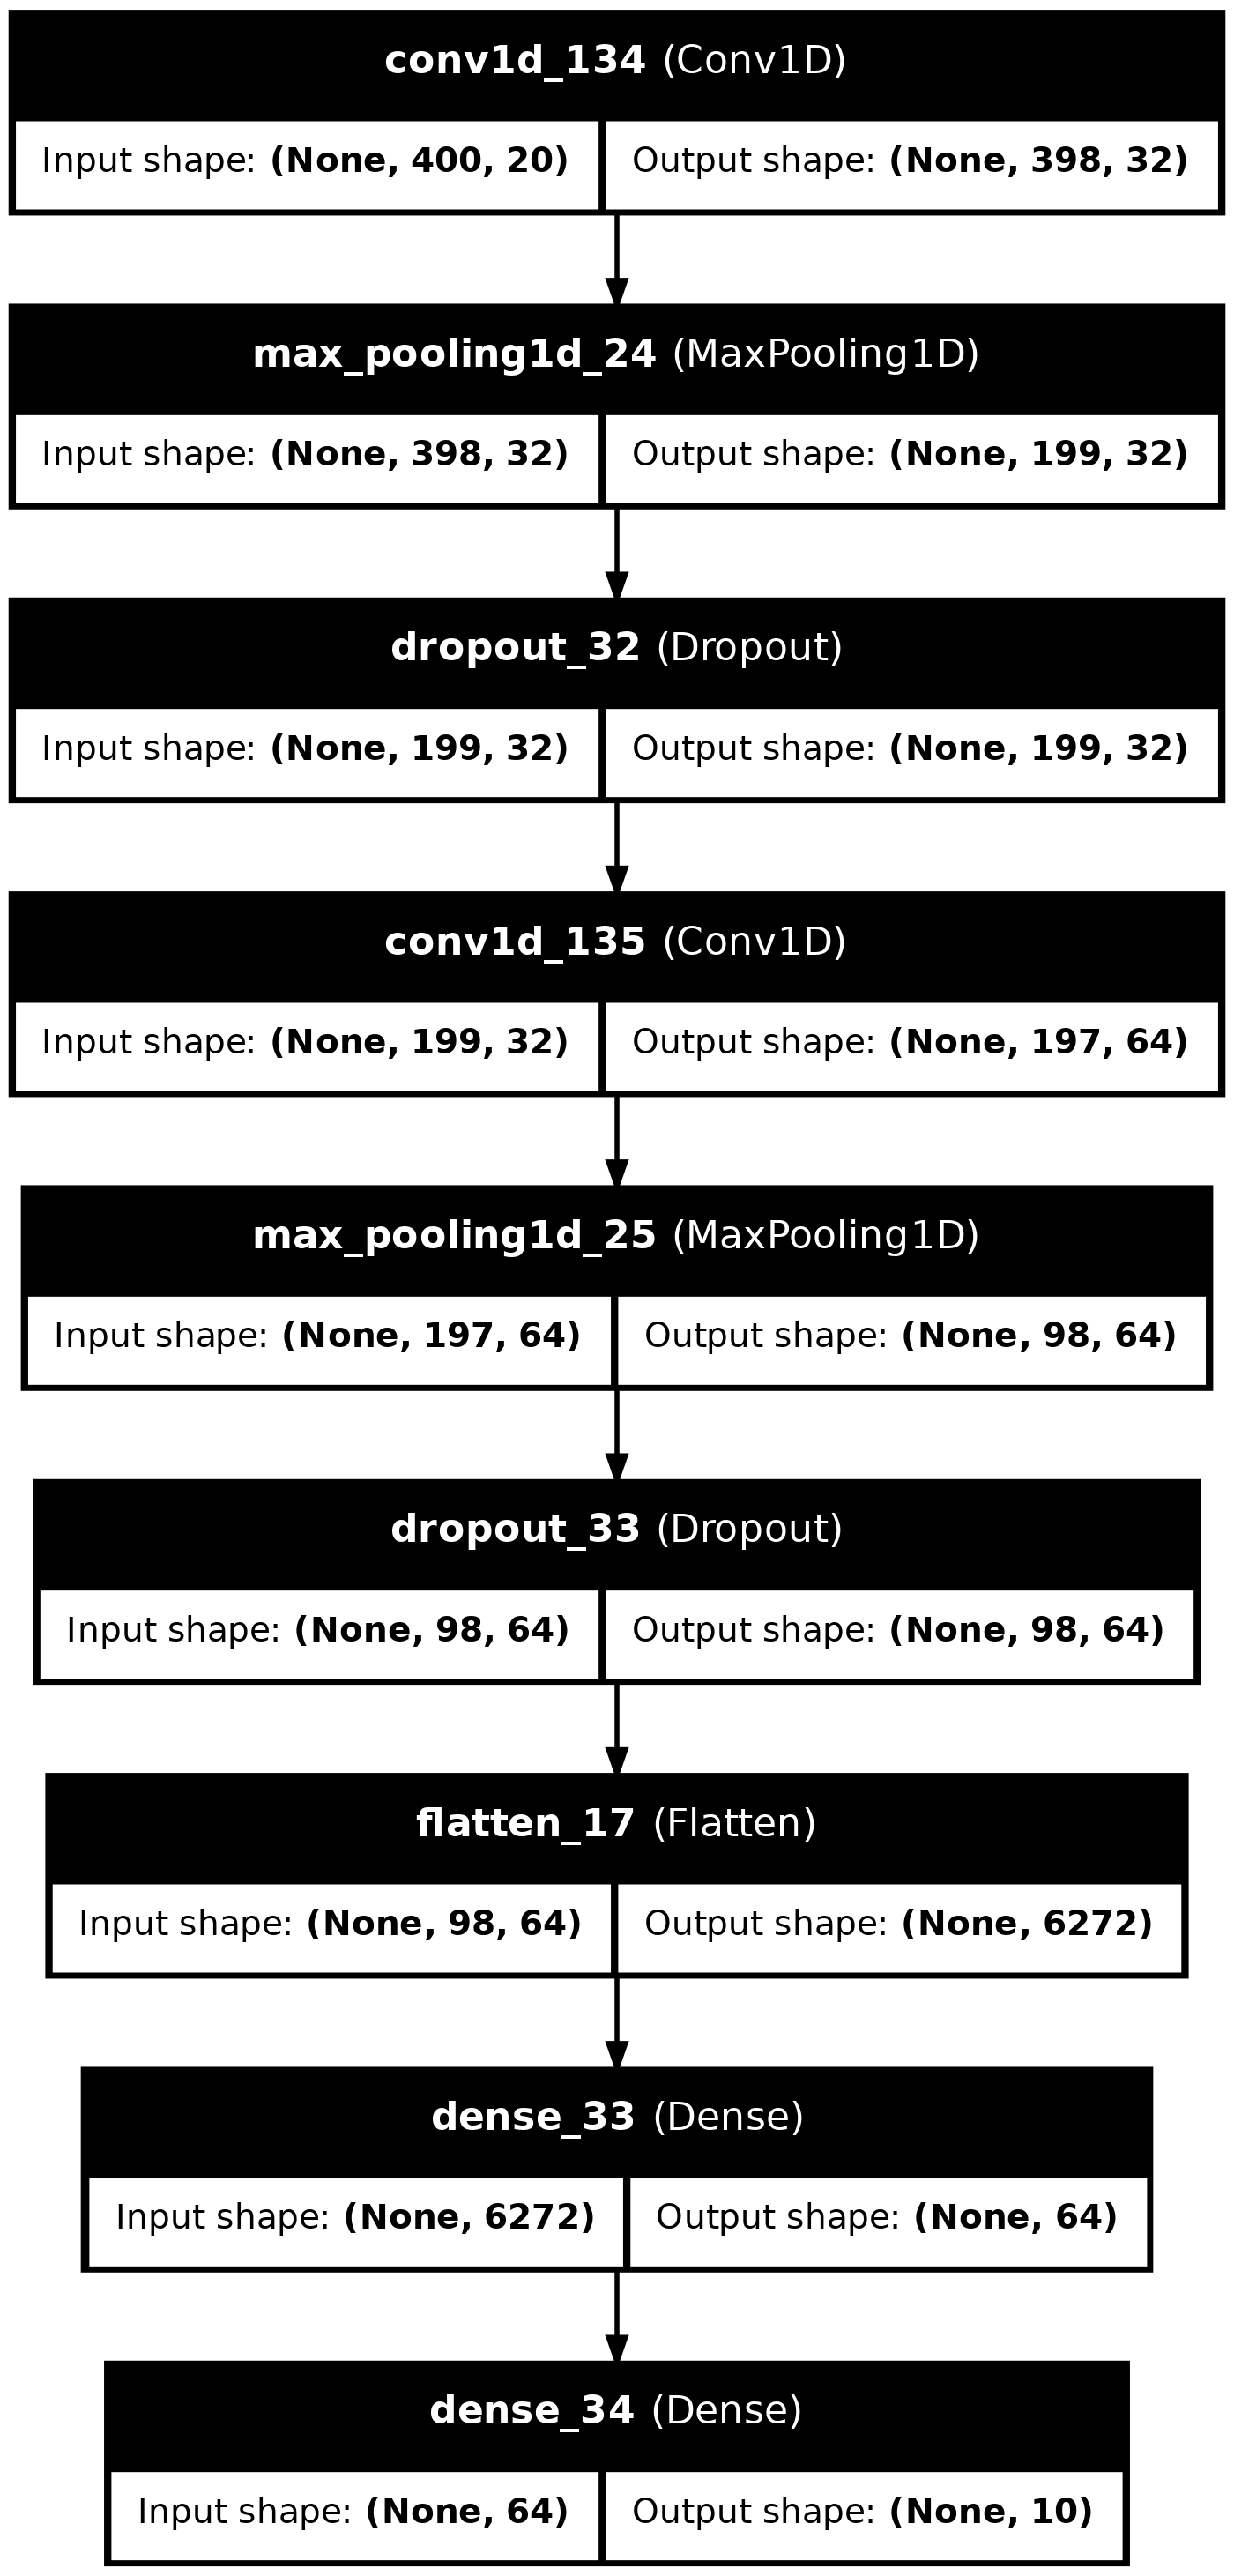

In [130]:
model_CNN = cnn()

# Print the model summary
model_CNN.summary()

# Visualize the model
plot_model(model_CNN, to_file='model_CNN.png', show_shapes=True, show_layer_names=True)

## Model training

### Definition of the seed function for reproductibility

In [131]:
def reset_seeds(seed = 42):
   np.random.seed(seed) 
   python_random.seed(seed)
   tf.random.set_seed(seed)

### Training

In [132]:
reset_seeds()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_CNN = model_CNN.fit(X_train_cut, 
                            y_train, 
                            epochs=50, 
                            batch_size=64,
                            validation_split=0.2,
                            callbacks=[early_stopping])
                    

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.2764 - loss: 2.2072 - val_accuracy: 0.3247 - val_loss: 2.0733
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3803 - loss: 1.9042 - val_accuracy: 0.4433 - val_loss: 1.9289
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4959 - loss: 1.7009 - val_accuracy: 0.5309 - val_loss: 1.7040
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6079 - loss: 1.4285 - val_accuracy: 0.5954 - val_loss: 1.4467
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7035 - loss: 1.1744 - val_accuracy: 0.6624 - val_loss: 1.2805
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7572 - loss: 1.0135 - val_accuracy: 0.6701 - val_loss: 1.1753
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7911 - loss: 0.8916 - val_accuracy: 0.6830 - val_loss: 1.1712
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8030 - loss: 0.8438 - val_accuracy: 0.7423 - v

### Analysis of model performances

#### Plot accuracy and loss evolution

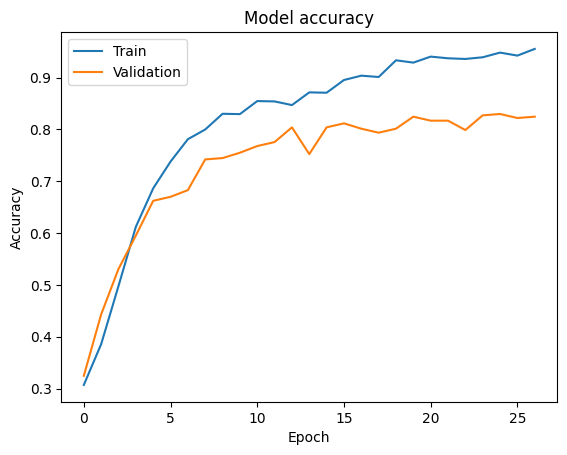

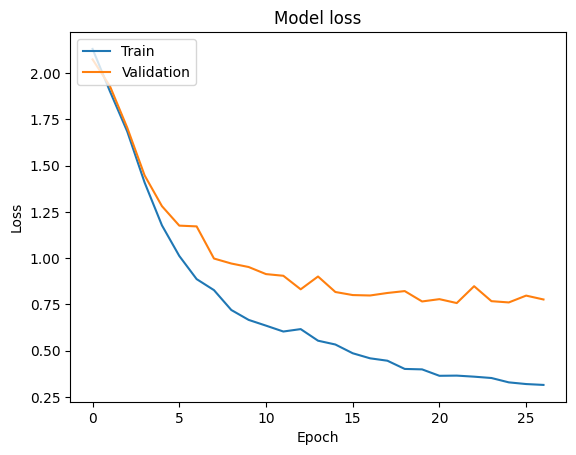

In [133]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


plot_history(history_CNN)

#### Confusion matrix

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


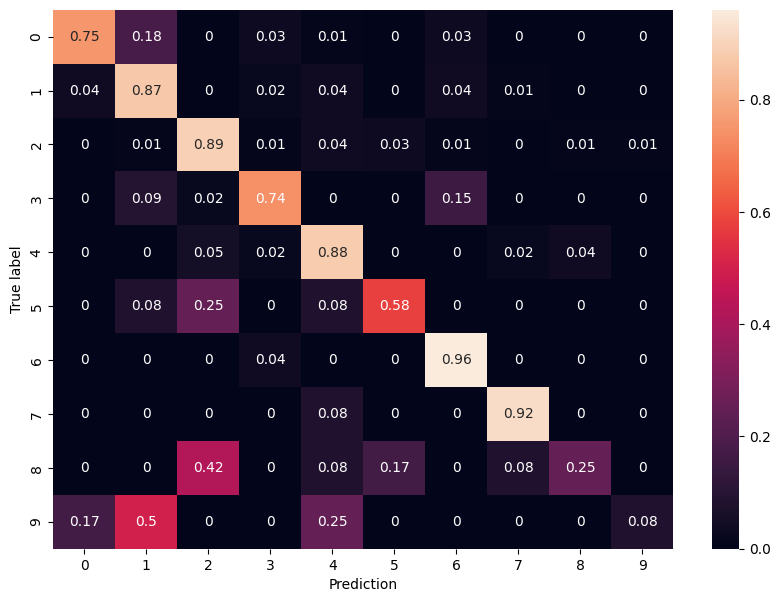

In [134]:
predictions = model_CNN.predict(X_test)
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), 
                               np.argmax(predictions, axis=1),
                               normalize='true') 
conf_matrix = np.round(conf_matrix, 2)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('True label')
plt.show()

The classification using this model is noverfitting and not able to generalize well enough. 
It is mainly predicting the 2 largest classes. 

#### Performances on the test set

In [135]:
# Calculate performance on the test set
loss, accuracy = model_CNN.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7979 - loss: 0.8960
Test loss: 0.8445209860801697
Test accuracy: 0.8123711347579956


# ResNet

What I tried to improve the performances of this ResNet : 

- add weight to underrepresented large classes

- reducing learning rate (to 10^-4)

- increase the patience to 10 for early stopping. 

## Define the model

In [136]:
# Define the residual module
def residual_module(input, channels, kernel_size=3):
    """
    Defines a single residual block.
    
    Args:
    - input: Input tensor.
    - channels: Number of filters for Conv1D layers.
    - kernel_size: Kernel size for Conv1D layers.
    
    Returns:
    - output: Output tensor after the residual block.
    """
    x_shortcut = input  # Shortcut connection (skip connection)
    
    # First Conv1D layer
    x = BatchNormalization()(input)
    x = Activation('relu')(x)
    x = Conv1D(channels, kernel_size=1, padding='same')(x)

    # Second Conv1D layer
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(channels, kernel_size=kernel_size, padding='same')(x)
    
    # Add the shortcut connection
    output = Add()([x, x_shortcut])
    
    return output

# Define the ResNet architecture
def resnet2(input_shape=(400, 20), num_classes=10):
    """
    Creates a simple 1D Residual Network (ResNet) for classification tasks.
    
    Args:
    - input_shape: Shape of the input data (time steps, features).
    - num_classes: Number of output classes for classification.
    
    Returns:
    - model: The complete ResNet model.
    """
    n_residual = 4  # Number of residual modules in the network
    print("Simple residual network with {} modules".format(n_residual))

    # Define the input layer with the shape of the PSSM matrices (400 time steps, 20 features)
    inputs = Input(shape=input_shape)

    # Pass the input through the residual blocks
    residual_i = inputs
    for _ in range(n_residual):
        residual_i = residual_module(residual_i, channels=20)  # Each residual block has 20 filters

    # Apply global average pooling (1D) with a pooling size of 2 and stride of 1
    gavg_1 = AveragePooling1D(pool_size=2, strides=1)(residual_i)

    # Flatten the output to prepare it for the fully connected (Dense) layer
    flat_1 = Flatten()(gavg_1)

    # Dense output layer with 'num_classes' neurons and softmax activation
    # Softmax is used for multi-class classification
    output = Dense(num_classes, activation="softmax")(flat_1)

    # Define the model by specifying the inputs and outputs
    model = Model(inputs=inputs, outputs=output)

    return model


In [137]:
# Create the ResNet model
input_shape = (400, 20)  # 400 time steps and 20 features (PSSM matrix size)
num_classes = 10         # Number of classes for classification
model_resnet_2 = resnet2(input_shape=input_shape, num_classes=num_classes)

# Visualize the model architecture, saving it to a file
plot_model(model_resnet_2, to_file="residual.png", show_shapes=True, show_layer_names=True)

# Print the summary of the model architecture
print(model_resnet_2.summary())

# Compile the model with Adam optimizer
model_resnet_2.compile(optimizer=Adam(learning_rate=1e-4), 
              loss="categorical_crossentropy", 
              metrics=['accuracy'],
              weighted_metrics=['accuracy'])

Simple residual network with 4 modules


Model: "functional_119"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 400, 20)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ input_layer_21[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_136 (Conv1D) │ (None, 400, 20)   │        420 │ activation_98[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ conv1d_136[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_99       │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_137 (Conv1D) │ (None, 400, 20)   │      1,220 │ activation_99[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_53 (Add)        │ (None, 400, 20)   │          0 │ conv1d_137[0][0], │
│                     │                   │            │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ add_53[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_100      │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_138 (Conv1D) │ (None, 400, 20)   │        420 │ activation_100[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ conv1d_138[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_101      │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_139 (Conv1D) │ (None, 400, 20)   │      1,220 │ activation_101[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_54 (Add)        │ (None, 400, 20)   │          0 │ conv1d_139[0][0], │
│                     │                   │            │ add_53[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ add_54[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_102      │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_140 (Conv1D) │ (None, 400, 20)   │        420 │ activation_102[0… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 87,010 (339.88 KB)

 Trainable params: 86,690 (338.63 KB)

 Non-trainable params: 320 (1.25 KB)

None


## Train the model

In [138]:
# Define class weights for a better training
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(classes_Y),
                                                  y=classes_Y)
class_weights_dict = dict(enumerate(class_weights))

# Train the model
reset_seeds()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_resnet_2 = model_resnet_2.fit(X_train_cut, y_train, 
                             validation_split=0.2, 
                             epochs=50, 
                             batch_size=50, 
                             class_weight=class_weights_dict)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.1278 - loss: 2.9194 - weighted_accuracy: 0.1140 - val_accuracy: 0.1572 - val_loss: 2.2809 - val_weighted_accuracy: 0.1572
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.2622 - loss: 2.0334 - weighted_accuracy: 0.2667 - val_accuracy: 0.1804 - val_loss: 2.2587 - val_weighted_accuracy: 0.1804
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3752 - loss: 1.6430 - weighted_accuracy: 0.4317 - val_accuracy: 0.2113 - val_loss: 2.2229 - val_weighted_accuracy: 0.2113
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4720 - loss: 1.3488 - weighted_accuracy: 0.5605 - val_accuracy: 0.2216 - val_loss: 2.1880 - val_weighted_accuracy: 0.2216
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5726 - loss: 1.1152 - weighted_accuracy: 0.6555 - val_accuracy: 0.2139 - val_loss: 2.1553 - val_weighted_accuracy: 0.2139
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0

## Evaluate the performances

### Accuracy and loss evolution during training

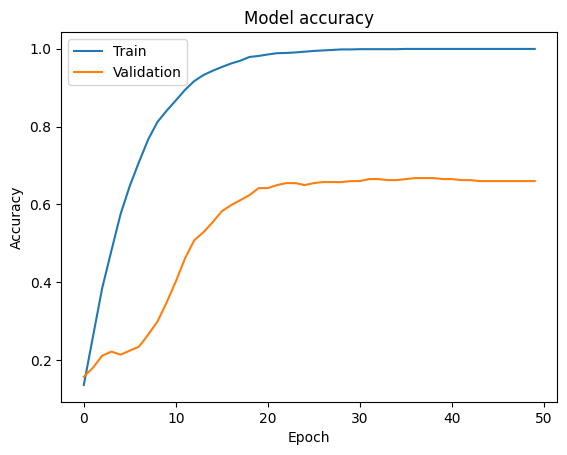

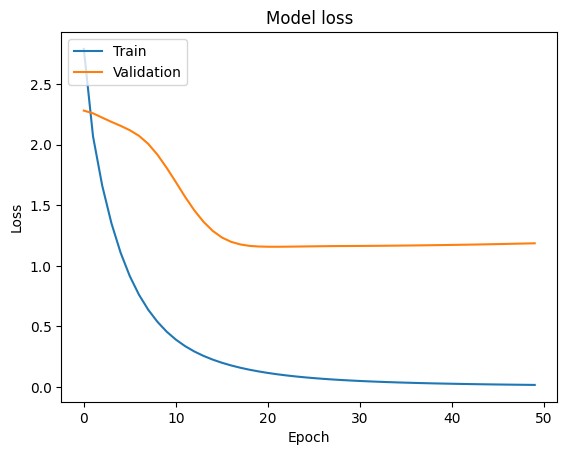

In [139]:
# Plot the history
plot_history(history_resnet_2)

### Confusion matrix

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


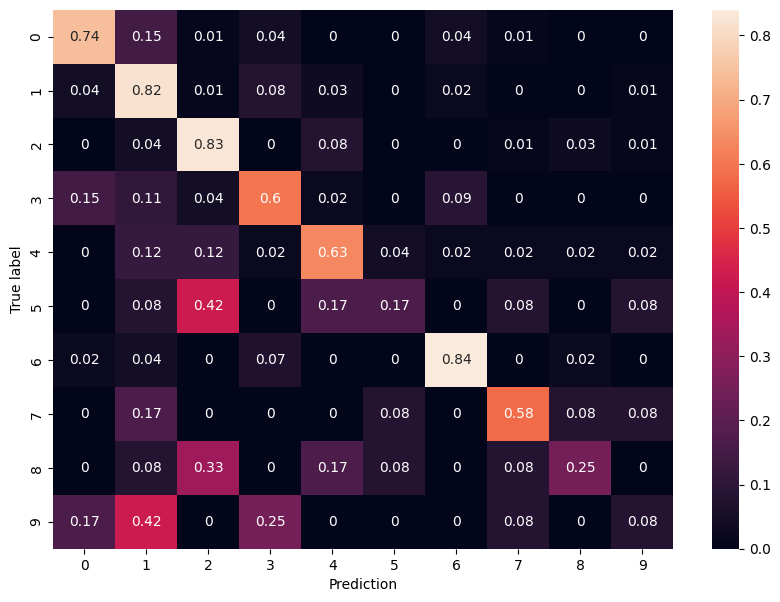

In [140]:
predictions = model_resnet_2.predict(X_test)
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), 
                               np.argmax(predictions, axis=1),
                               normalize='true') 
conf_matrix = np.round(conf_matrix, 2)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('True label')
plt.show()

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


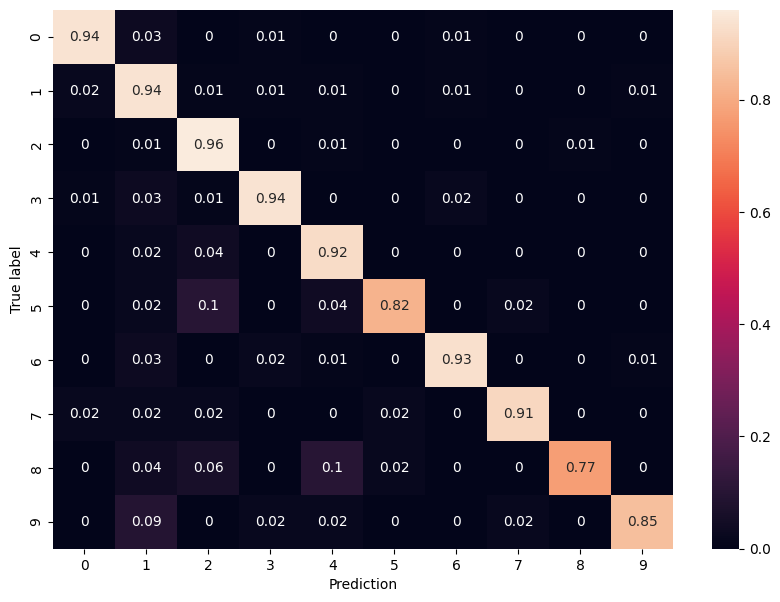

In [141]:
# Check confusion matrix on train set to see if under represented classes are predicted correctly
predictions = model_resnet_2.predict(X_train_cut)
conf_matrix = confusion_matrix(np.argmax(y_train, axis=1), 
                               np.argmax(predictions, axis=1),
                               normalize='true') 
conf_matrix = np.round(conf_matrix, 2)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('True label')
plt.show()

# ResNet optimization  

Changed : 

- Added L2 Regularization to Conv1D layers.
- Added Dropout to reduce overfitting.
- Reduced the number of residual blocks to make the model less complex.
- Lowered the learning rate for slower, more stable training.
- Switched the optimizer to Adam with a smaller learning rate.

It didn't increase the accuracy.
